In [1]:
!pip install librosa moviepy


In [5]:
video_file_path = '/content/dia0_utt0.mp4' # Update this path


In [6]:
from moviepy.editor import VideoFileClip

video_clip = VideoFileClip(video_file_path)
audio_clip = video_clip.audio
audio_clip.write_audiofile('audio_file.wav')


MoviePy - Writing audio in audio_file.wav


MoviePy - Done.


In [ ]:

##tried in local machine, change if you want to run in colab
from moviepy.editor import VideoFileClip
import os
import time

input_dir = 'MELD.Raw/train_splits'
output_dir = 'train_audio'
log_file_path = 'processed_files.log'
error_log_path = 'error_files.log'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

processed_files = set()
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as file:
        processed_files = set(file.read().splitlines())

processed_files_count = 0
max_files = 1000
throttle_delay = 1

for filename in os.listdir(input_dir):
    if filename.endswith(".mp4") and filename not in processed_files:
        if processed_files_count >= max_files:
            break

        video_file_path = os.path.join(input_dir, filename)
        try:
            video_clip = VideoFileClip(video_file_path)
            audio_clip = video_clip.audio
            audio_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.wav')
            audio_clip.write_audiofile(audio_file_path, verbose=False, logger=None)
            video_clip.close()
            audio_clip.close()
            processed_files.add(filename)
            processed_files_count += 1
            with open(log_file_path, 'a') as log_file:
                log_file.write(f"{filename}\n")
        except OSError as e:
            print(f"Error processing {filename}: {e}")
            with open(error_log_path, 'a') as error_log:
                error_log.write(f"{filename}\n")
        finally:
            time.sleep(throttle_delay)

print(f"Batch conversion completed. Processed {processed_files_count} files.")


### MFCC

In [10]:
filepaths = [f'/content/dia0_utt{i}.wav' for i in range(10)]


In [24]:
def compute_and_plot_mfccs(filepath, save_plot=True):
    # Load the audio file
    y, sr = librosa.load(filepath)
    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # You can adjust n_mfcc as needed

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC of {filepath}')
    plt.tight_layout()

    # Save or show the plot
    if save_plot:
        plt.savefig(f'{filepath}_mfcc.png')
        plt.show()

        plt.close()  # Close the plot to free memory
    else:
        plt.show()

    return mfccs


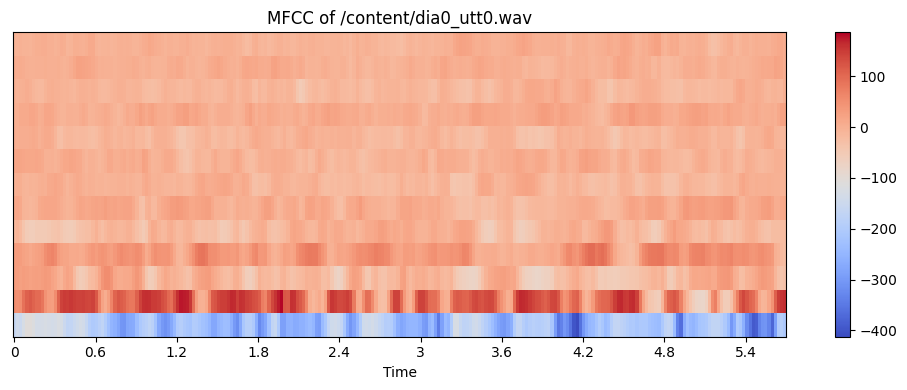

/content/dia0_utt0.wav: MFCC shape: (13, 246)


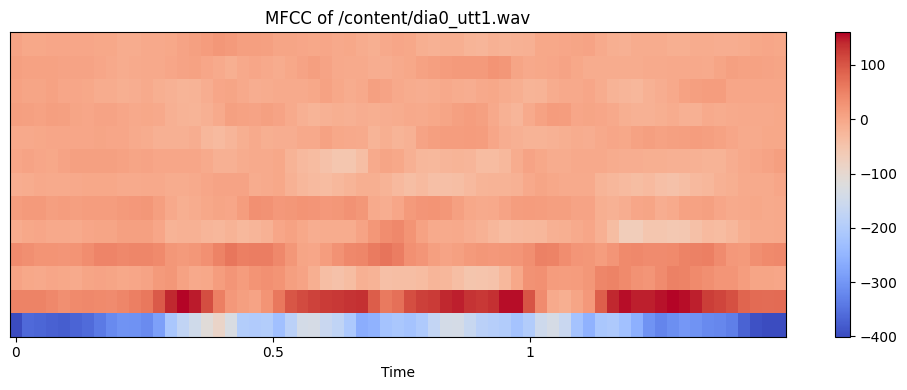

/content/dia0_utt1.wav: MFCC shape: (13, 65)


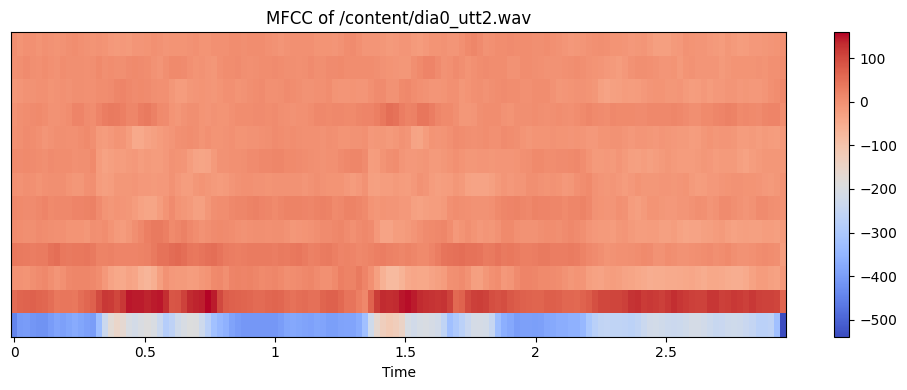

/content/dia0_utt2.wav: MFCC shape: (13, 128)


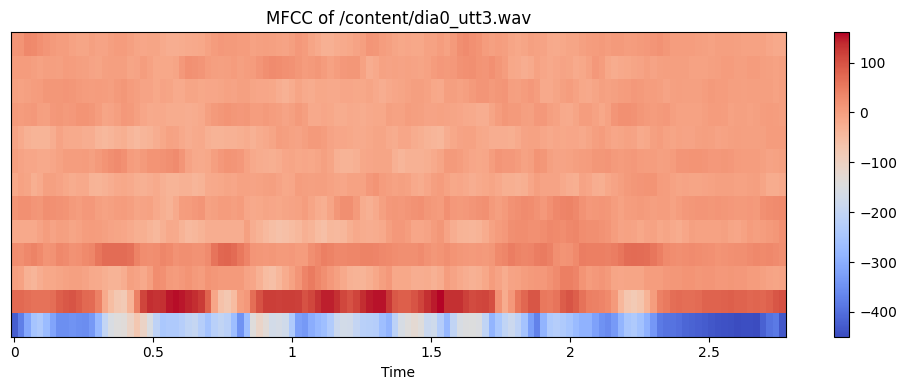

/content/dia0_utt3.wav: MFCC shape: (13, 120)


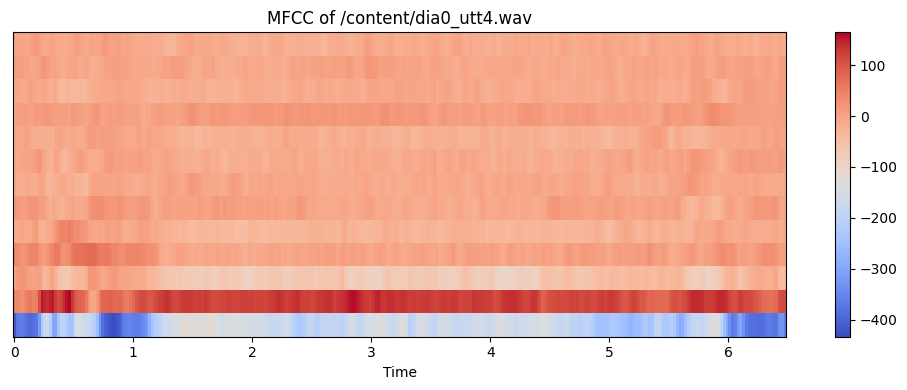

/content/dia0_utt4.wav: MFCC shape: (13, 280)


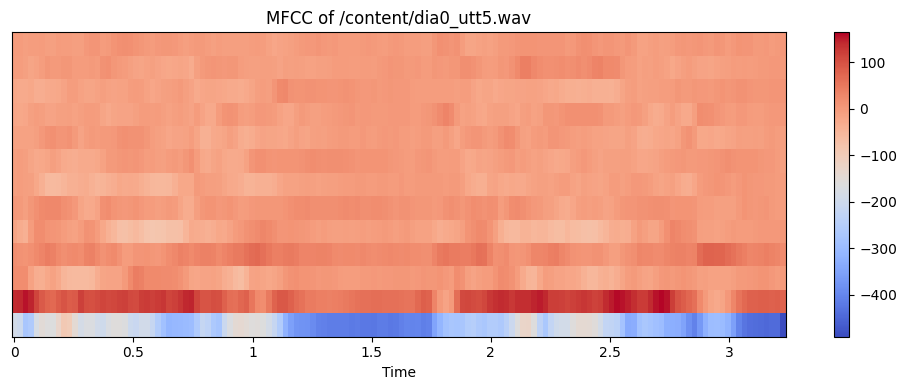

/content/dia0_utt5.wav: MFCC shape: (13, 140)


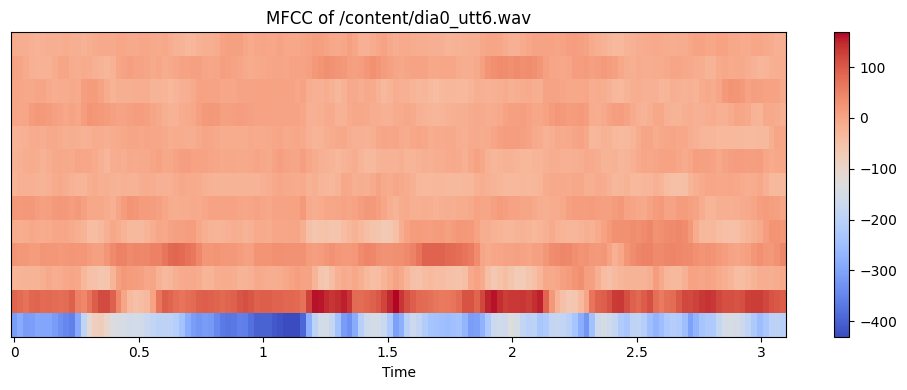

/content/dia0_utt6.wav: MFCC shape: (13, 134)


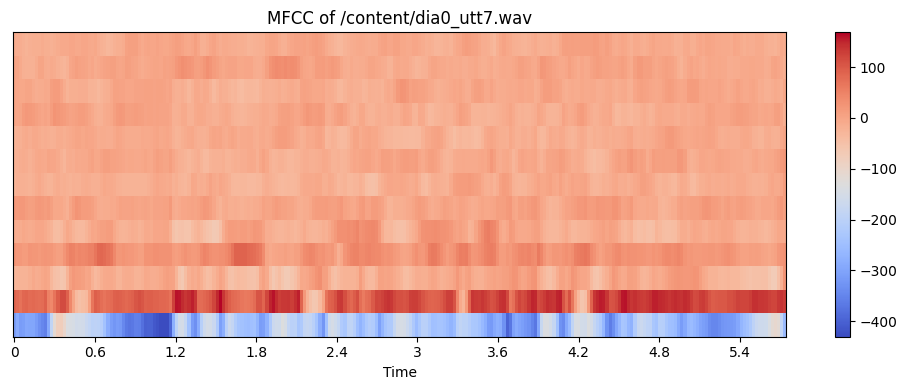

/content/dia0_utt7.wav: MFCC shape: (13, 248)


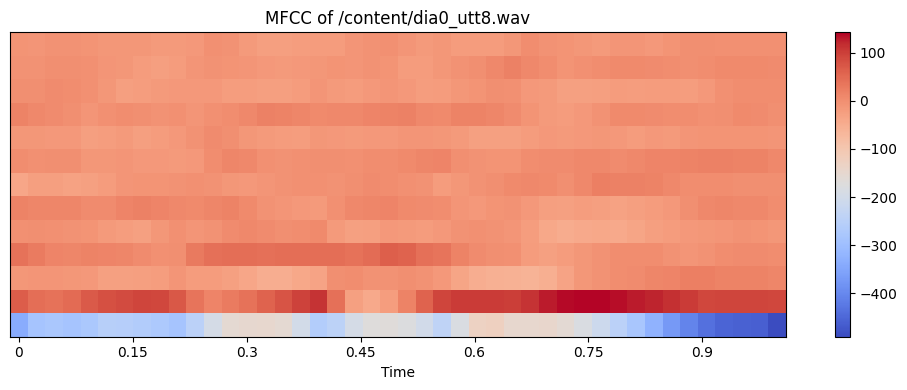

/content/dia0_utt8.wav: MFCC shape: (13, 44)


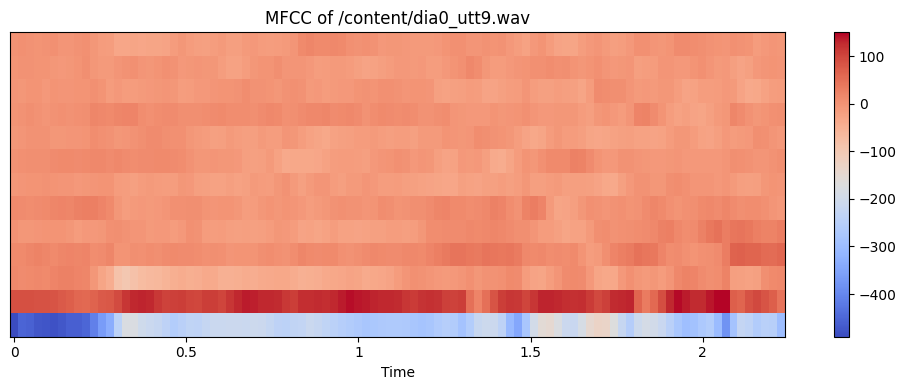

/content/dia0_utt9.wav: MFCC shape: (13, 97)


In [25]:
for filepath in filepaths:
    mfccs = compute_and_plot_mfccs(filepath)
    print(f'{filepath}: MFCC shape: {mfccs.shape}')


## OpenSmile Features

In [18]:
!pip install opensmile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168840 sha256=391c24dd90f27d5e8d1af0b3ad635c9b8fedca8b53dc9f21b82c5de7d5f6baf7
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639


In [20]:
import opensmile
import pandas as pd

def extract_features_and_save_csv(filepaths, output_csv_path):
    # Initialize openSMILE
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    features_list = []

    # Process each file and collect the features
    for filepath in filepaths:
        features = smile.process_file(filepath)
        # Add a column to identify the file
        features['filename'] = filepath
        features_list.append(features)

    # Concatenate all features into a single DataFrame
    all_features_df = pd.concat(features_list, axis=0)

    all_features_df.to_csv(output_csv_path, index=False)
    print(f'All features saved to {output_csv_path}')

    return all_features_df

# List of file paths
filepaths = [f'/content/dia0_utt{i}.wav' for i in range(10)]

# Output CSV path
output_csv_path = '/content/extracted_features.csv'

# Extract features for all files and save to CSV
all_features_df = extract_features_and_save_csv(filepaths, output_csv_path)


All features saved to /content/extracted_features.csv


## MELSPECTROGRAM

In [21]:
filepaths = [f'/content/dia0_utt{i}.wav' for i in range(10)]


In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_spectrogram(filepath):
    # Load the audio file
    y, sr = librosa.load(filepath)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram of {filepath}')
    plt.tight_layout()
    plt.show()


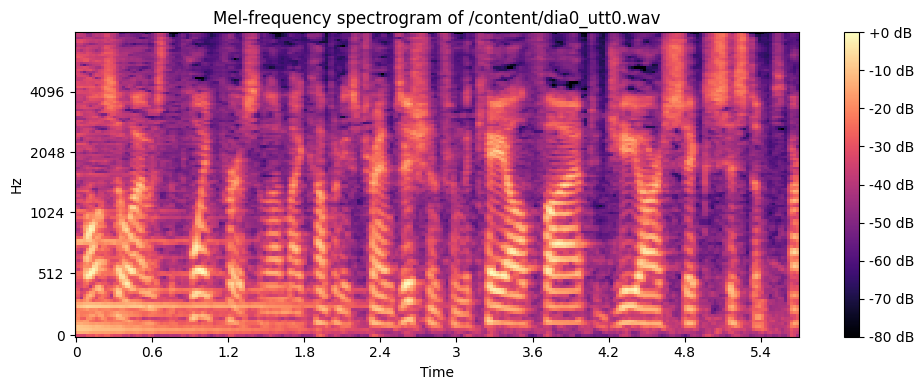

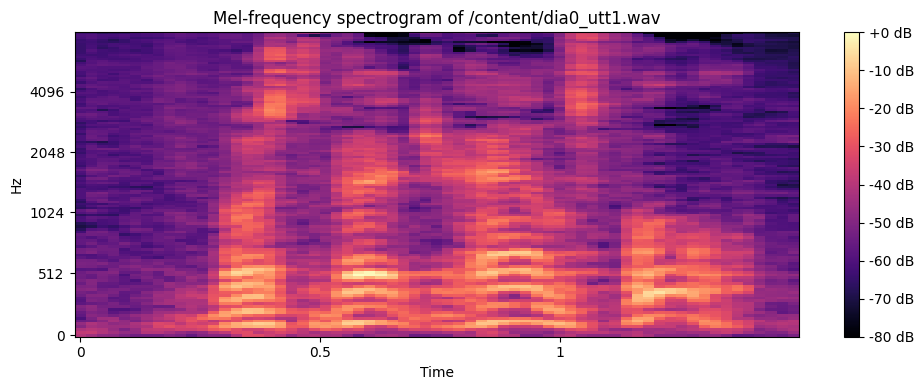

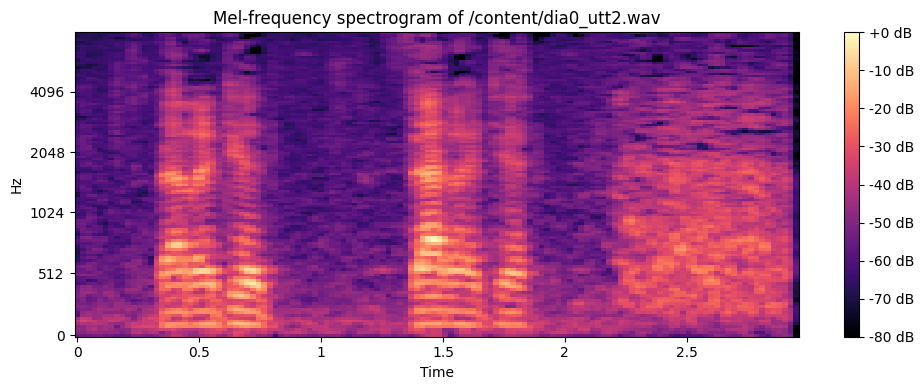

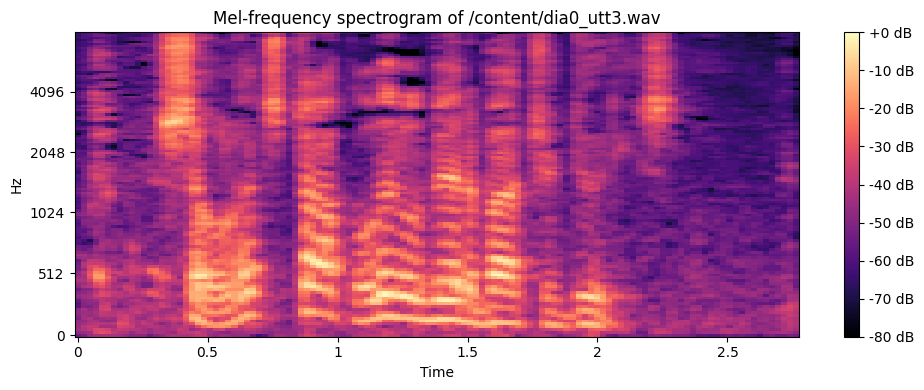

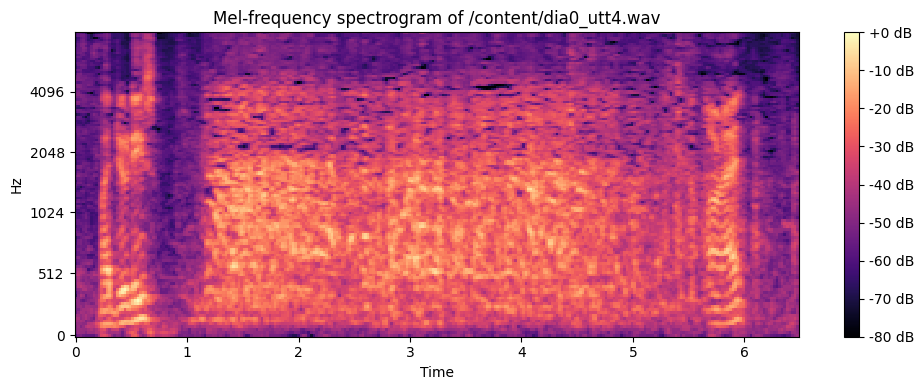

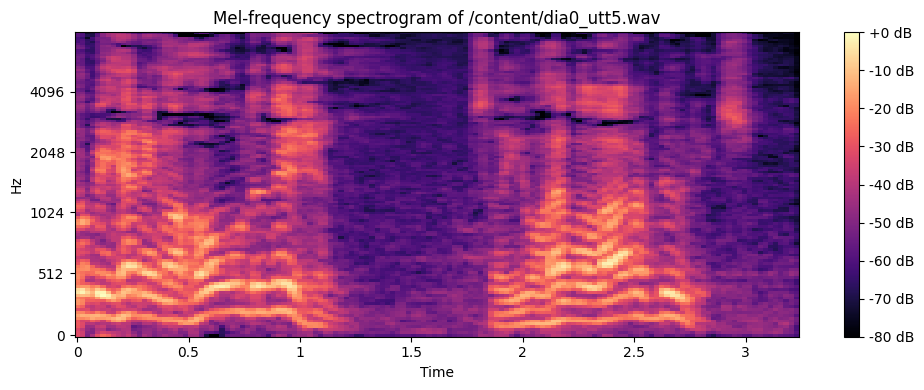

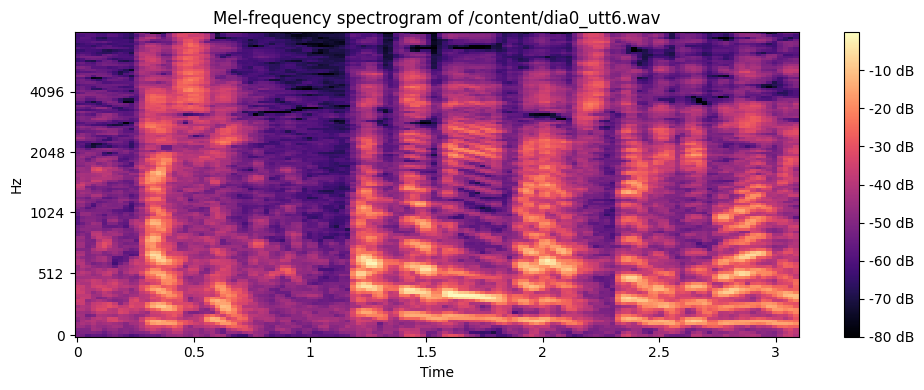

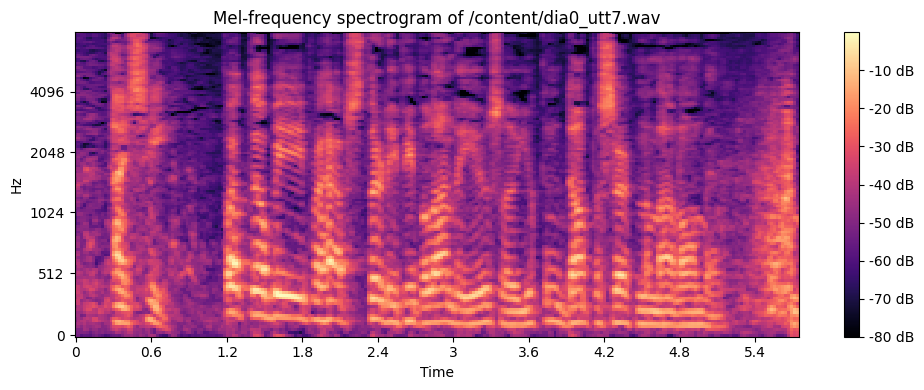

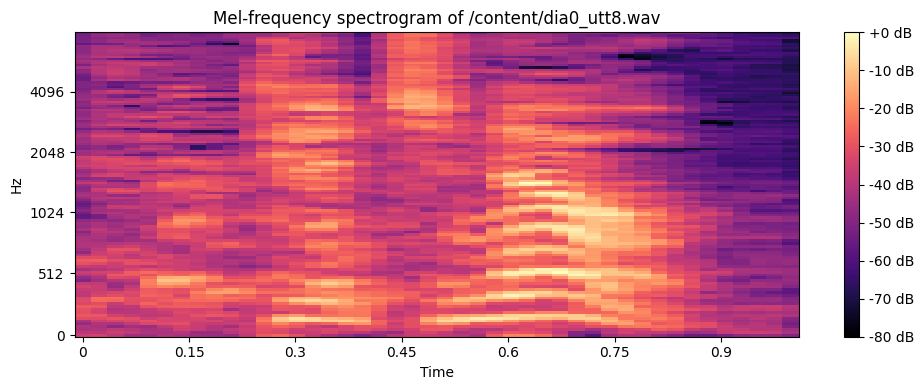

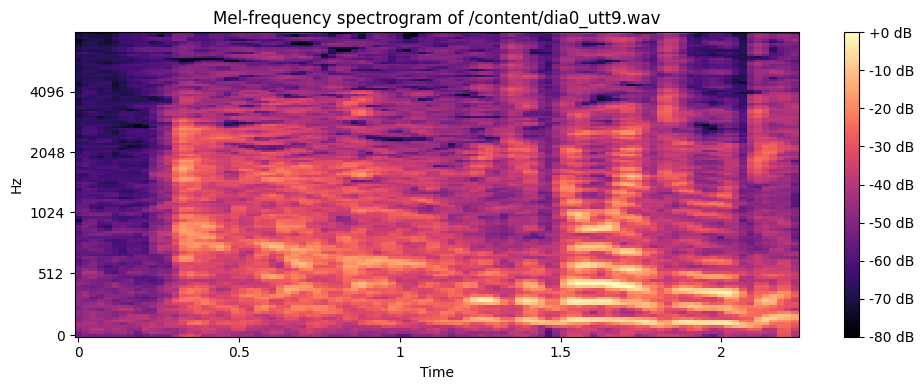

In [23]:
for filepath in filepaths:
    create_spectrogram(filepath)


FOR TRAIN TEST DEV

In [ ]:
from moviepy.editor import AudioFileClip
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np



input_dir = 'open-set-emotion-recognition/audio_MELD/train_audio'
log_dir = 'open-set-emotion-recognition/log_dir'
output_dir = 'open-set-emotion-recognition/audio_spectrograms/train_audio'
log_file_path = 'open-set-emotion-recognition/log_dir/processed_files_audio_spectrogram.log'
error_log_path = 'open-set-emotion-recognition/log_dir/error_files_audio_spectrogram.log'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

processed_files = set()
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as file:
        processed_files = set(file.read().splitlines())

processed_files_count = 0
max_files = 4000 
throttle_delay = 1 
def create_spectrogram(filename, audio_file_path, output_file_path):
    y, sr = librosa.load(audio_file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {filename}')
    plt.tight_layout()
    plt.savefig(output_file_path)
    plt.close()

for filename in os.listdir(input_dir):
    if filename.endswith((".wav", ".mp3")) and filename not in processed_files:
        if processed_files_count >= max_files:
            break

        audio_file_path = os.path.join(input_dir, filename)
        output_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
        try:
            create_spectrogram(filename, audio_file_path, output_file_path)
            processed_files.add(filename)
            processed_files_count += 1
            with open(log_file_path, 'a') as log_file:
                log_file.write(f"{filename}\n")
            print(f"Processed {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            with open(error_log_path, 'a') as error_log:
                error_log.write(f"{filename}: {e}\n")
        finally:
            time.sleep(throttle_delay)

print(f"Batch conversion completed. Processed {processed_files_count} files.")


## FEATURE EXTRACTION BASED ON GITHUB SENT BY ABHI

In [2]:
!pip install transformers
!pip install tensorboardx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.3 MB/s eta 0:00:00


### FOR ALL TRAIN TEST AND DEV 

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import os
from PIL import Image
from scipy.fftpack import fft
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter

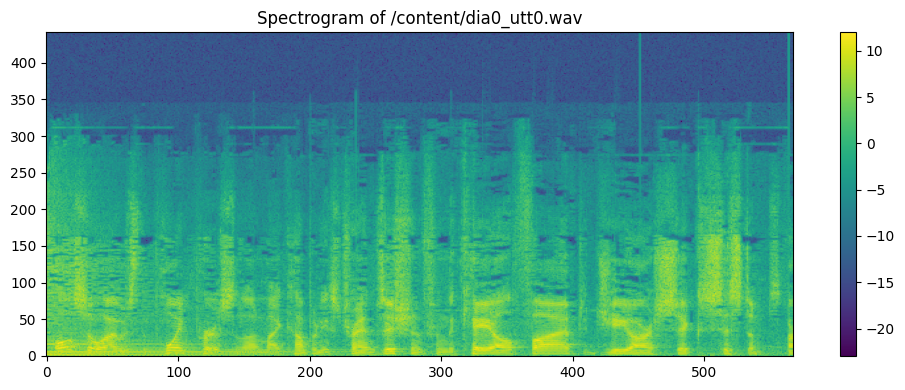

/content/dia0_utt0.wav: Spectrogram shape: (568, 442)


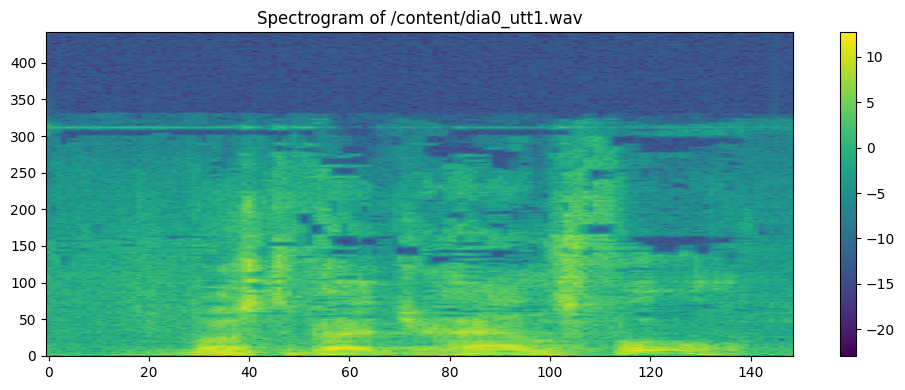

/content/dia0_utt1.wav: Spectrogram shape: (149, 442)


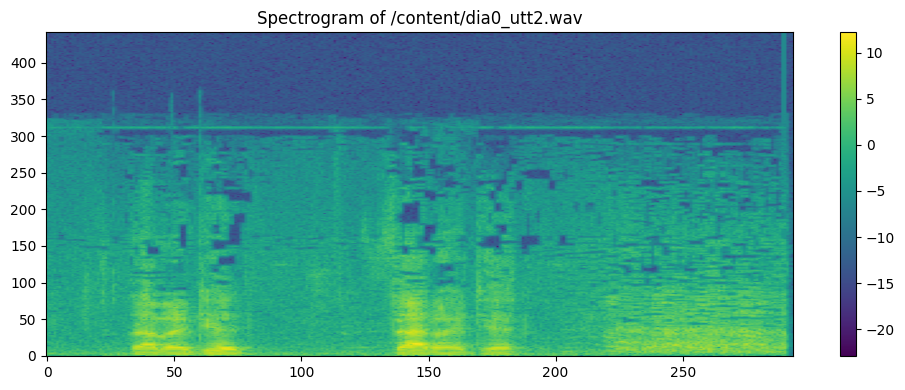

/content/dia0_utt2.wav: Spectrogram shape: (294, 442)


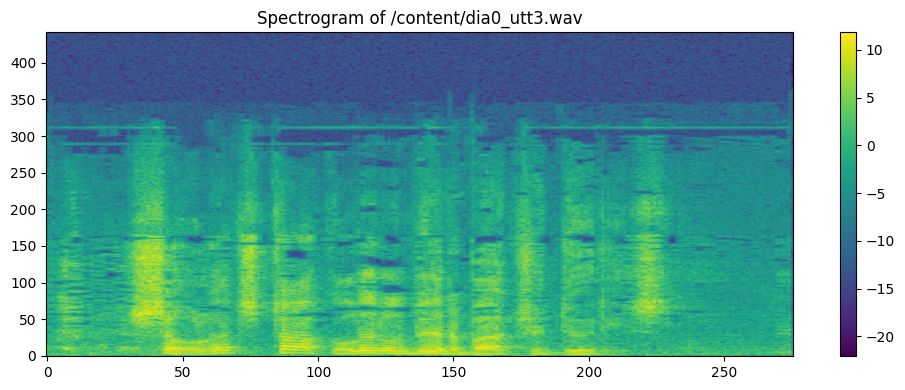

/content/dia0_utt3.wav: Spectrogram shape: (276, 442)


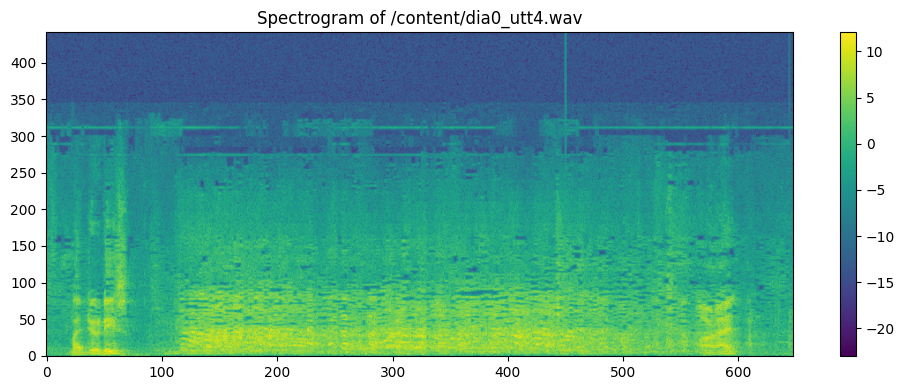

/content/dia0_utt4.wav: Spectrogram shape: (648, 442)


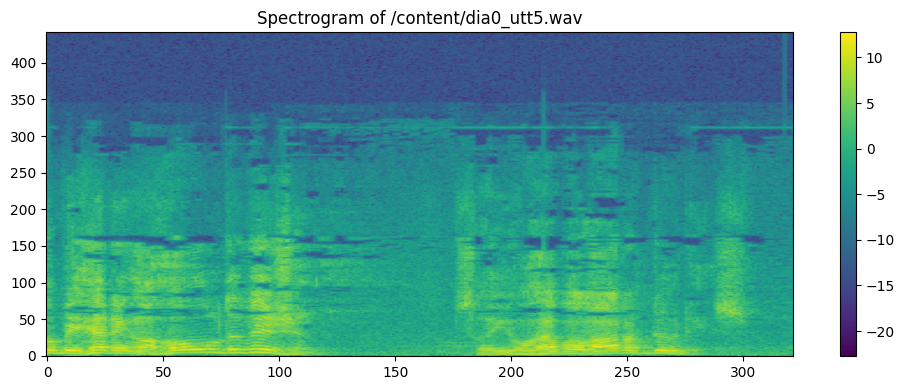

/content/dia0_utt5.wav: Spectrogram shape: (322, 442)


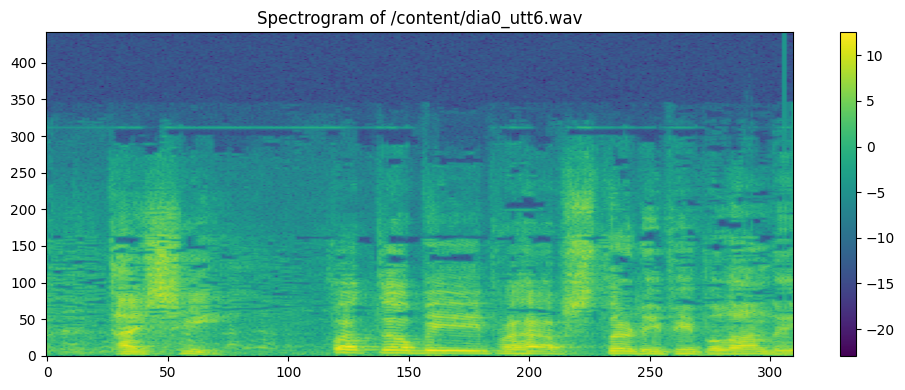

/content/dia0_utt6.wav: Spectrogram shape: (310, 442)


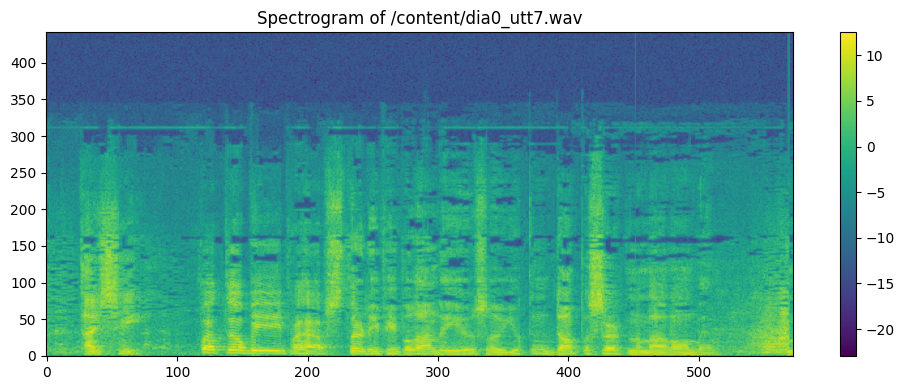

/content/dia0_utt7.wav: Spectrogram shape: (573, 442)


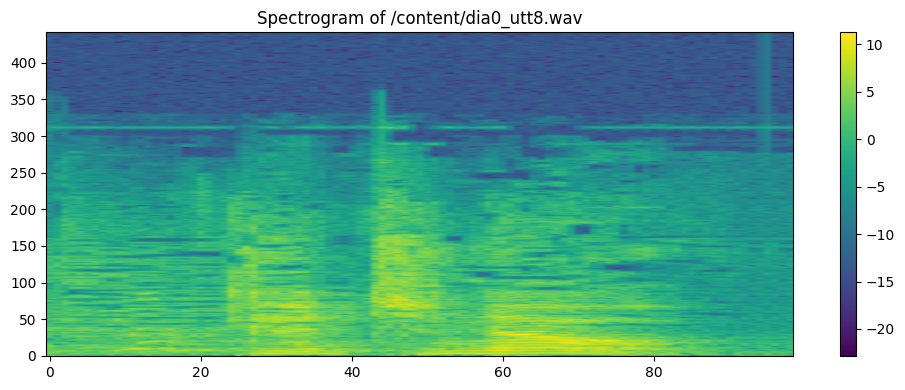

/content/dia0_utt8.wav: Spectrogram shape: (99, 442)


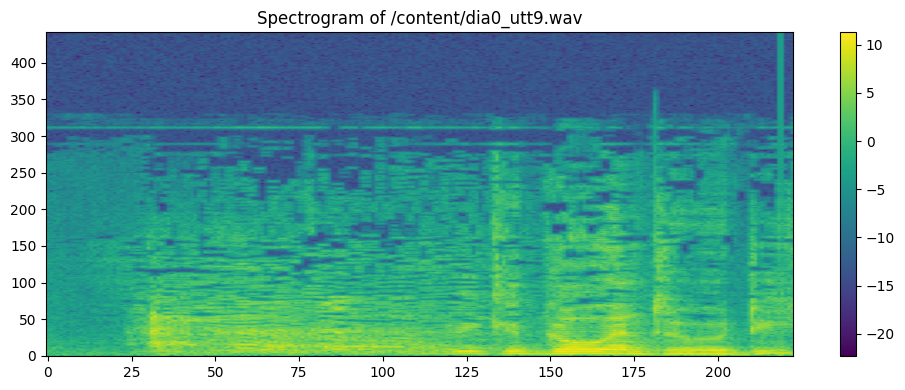

/content/dia0_utt9.wav: Spectrogram shape: (223, 442)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    audio_length = len(audio)
    window_size_samples = int(round(window_size * sample_rate / 1e3))
    step_size_samples = int(round(step_size * sample_rate / 1e3))

    # Adjust nperseg and noverlap for very short audio
    nperseg = min(window_size_samples, audio_length // 3)
    noverlap = min(step_size_samples, nperseg // 2, audio_length // 4)

    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

def audio2spectrogram_and_save(filepath):
    samplerate, test_sound = wavfile.read(filepath, mmap=True)
    if test_sound.ndim > 1:
        test_sound = test_sound.mean(axis=1)
    _, spectrogram = log_specgram(test_sound, samplerate)
    plt.figure(figsize=(10, 4))  # Adjust size as needed
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.title(f'Spectrogram of {filepath}')
    plt.colorbar()
    plt.tight_layout()
    # Save the plot instead of showing it
    plt.savefig(f'{filepath}_spectrogram.png')
    plt.show()
    plt.close()  # Close the plot to free memory
    return spectrogram



def audio2wave(filepath):
    fig = plt.figure(figsize=(5,5))
    samplerate, test_sound  = wavfile.read(filepath,mmap=True)
    plt.plot(test_sound)
# Example usage
filepaths = [f'/content/dia0_utt{i}.wav' for i in range(10)]
for filepath in filepaths:
    spectrogram = audio2spectrogram_and_save(filepath)
    print(f'{filepath}: Spectrogram shape: {spectrogram.shape}')


### FOR TRAIN TEST AND DEV

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
import time
from google.colab import drive
drive.mount('/content/drive')
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate, window='hann',
                                            nperseg=nperseg, noverlap=noverlap, detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

def process_audio_file(filepath, output_dir):
    sample_rate, audio = wavfile.read(filepath)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    _, spectrogram = log_specgram(audio, sample_rate)
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.title(f'Spectrogram of {os.path.basename(filepath)}')
    plt.colorbar()
    plt.tight_layout()
    output_filepath = os.path.join(output_dir, os.path.splitext(os.path.basename(filepath))[0])
    plt.savefig(output_filepath)
    plt.close()

input_dir = '/content/drive/My Drive/open_emotion_project/test_audio'
log_dir = '/content/drive/My Drive/open_emotion_project/log_dir'
output_dir = '/content/drive/My Drive/open_emotion_project/log_apectrogram/test_audio'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_file_path = os.path.join(log_dir, 'processed_files_test.log')
error_log_path = os.path.join(log_dir, 'error_files_test.log')

max_files = 3000
throttle_delay = 0

processed_files = set()
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as file:
        processed_files = set(file.read().splitlines())

processed_files_count = 0
for filename in os.listdir(input_dir):
    if filename.endswith(".wav") and filename not in processed_files:
        if processed_files_count >= max_files:
            break

        try:
            process_audio_file(os.path.join(input_dir, filename), output_dir)
            processed_files.add(filename)
            processed_files_count += 1
            with open(log_file_path, 'a') as log_file:
                log_file.write(f"{filename}\n")
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            with open(error_log_path, 'a') as error_log:
                error_log.write(f"{filename}: {e}\n")
        finally:
            time.sleep(throttle_delay)

print(f"Batch conversion completed. Processed {processed_files_count} files.")
